### TensorFlow basics

In [1]:
import tensorflow as tf
import numpy as np
import time

---
The fundamental objects we have in tensorflow are **graphs** and **sessions**.

In [2]:
graph = tf.Graph()
with graph.as_default():
    a = tf.Variable(60)
    b = tf.Variable(6)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print tf.add(a, b).eval()

66


---
We can avoid explicitly create a graph if there is only one graph involved, but we always need to specify the session:

In [3]:
with tf.Session() as session:
    c = tf.Variable(70)
    d = tf.Variable(7)
    tf.global_variables_initializer().run()
    print tf.add(c, d).eval()

77


This can some times be inconvenient. For example, all the statements have to be in the same session clause:

In [4]:
with tf.Session() as session:
    c = tf.Variable(70)
    d = tf.Variable(7)
    tf.global_variables_initializer().run()

print 'If you leave the session at a point'

try:
    print tf.add(c, d).eval()
except Exception as e:
    print "You can't go back"

If you leave the session at a point
You can't go back


---
One solution is to create a session object:

In [5]:
sess = tf.Session()
i = tf.Variable(80)
j = tf.Variable(8)
sess.run(tf.global_variables_initializer())
print tf.add(i, j).eval(session = sess)

88


In [6]:
sess.close()

The `InteractiveSession` allows less typing (notice that we don't need `session = sess` or `sess.run`)

In [7]:
sess = tf.InteractiveSession()
k = tf.Variable(90)
l = tf.Variable(9)
tf.global_variables_initializer().run()
print tf.add(k, l).eval()
sess.close()

99


### MNIST dataset

A very popular toyset to demonstrate neural network is the mnist dataset. The dataset and the description can be found at <a href=http://yann.lecun.com/exdb/mnist/>Yann LeCun's website</a>. The package tensorflow also provide a function to load the dataset:

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
dir(mnist)

In [10]:
print 'The size of the training input:', mnist.train.images.shape
print 'The size of the training label:', mnist.train.labels.shape

The size of the training input: (55000, 784)
The size of the training label: (55000, 10)


The validation and the test sets can be loaded in the same way.

Below we demo a convenient way to save your data:

In [11]:
from six.moves import cPickle as pickle

In [12]:
set_filename = './saved_data.pkl'
to_be_saved = {'images': mnist.train.images,
               'labels': mnist.train.labels}

with open(set_filename, 'wb') as f:
    pickle.dump(to_be_saved, f, pickle.HIGHEST_PROTOCOL)

In [13]:
pickle_file = './saved_data.pkl'

with open(pickle_file, 'rb') as f:
    loaded_data = pickle.load(f)

images = loaded_data['images']
labels = loaded_data['labels']

### A simple logistic regression

Let's start with a **logistic regression** on a simple dataset. Below we visualize this toy dataset:

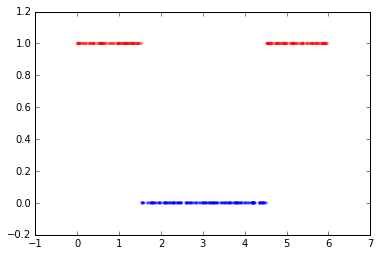

In [9]:
x_train = np.array(sorted(np.random.rand(400)*6)).reshape(-1, 1)
y_train = np.array([1]*100+[0]*200 + [1]*100).reshape(-1,1)

import matplotlib.pyplot as plt
%matplotlib inline
color  = map(lambda x: 'b' if x==0 else 'r', y_train)
plt.scatter(x_train, y_train, s=5, alpha=0.3, color= color)

Let's inspect the result from `sklearn`:

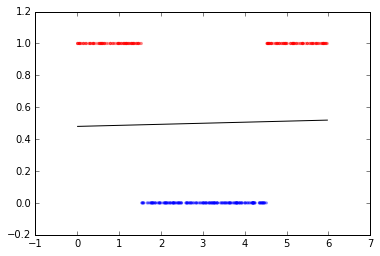

In [10]:
from sklearn import linear_model
logit = linear_model.LogisticRegression(C = 1e8)
logit.fit(x_train, y_train)
probability = logit.predict_proba(x_train)

plt.scatter(x_train, y_train, s=5, alpha=0.3, color= color)
plt.plot(x_train, probability[:,0], c='k')

---

Below we implement logistic regression with tensorflow. Here is the formula how logistic regression generates probability

<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/logistic.png height=200 width = 300>




Below pay attention to 

- the TensorFlow data types: **`constant`** and **`Variable`**.
- the **`forword propagation`** and the **`backpropagation`**.

In [11]:
sess = tf.InteractiveSession()

x = tf.constant(x_train, dtype=tf.float32)
y = tf.constant(y_train, dtype=tf.float32)
w = tf.Variable(tf.truncated_normal([1,1], stddev=0.1))
b = tf.Variable(tf.constant(0.1, shape=[1,1]))


y_lin = tf.add(tf.matmul(x, w), b)
log_likelihood = tf.reduce_mean(y_lin*y - tf.log(1+tf.exp(y_lin)), 0)
loss = -1*log_likelihood ### We may simply use the Python operators as well
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

steps = 200
tf.global_variables_initializer().run()
for i in range(steps):
    train_step.run()

The logloss we implemented above is:

<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/log_loss.png height=270 width = 450>

<br>

Since what we implemented here is nothing but the logistic regression. The result is as bad as the one from `sklearn`.

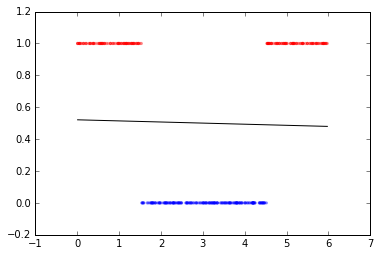

In [12]:
prob = tf.nn.sigmoid(y_lin).eval()
plt.scatter(x_train, y_train, s=5, alpha=0.3, color= color)
plt.plot(x_train, prob, c='k')
sess.close()

---

Let's add one hidden layer.

<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/first_hidden.png height=200 width = 300>
<br/>
Define the row vector 

$$w_1 = (\alpha^1, \alpha^2) \ \text{ and } \ b_1 = (\beta^1, \beta^2),$$

we may write the "formula" above with matrix notation:
<br/>
<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/first_hidden_2.png height=250 width = 375>
<br/>
Then we aggregate the two first layer prediction, to make a new one:
<br/>
<img src = https://s3-us-west-2.amazonaws.com/nycdatasciecneipynb/second_layer.png height=250 width = 375>

In [13]:
sess = tf.InteractiveSession()

x = tf.constant(x_train, dtype=tf.float32)
y = tf.constant(y_train, dtype=tf.float32)
w_1 = tf.Variable(tf.truncated_normal([1,2], stddev=0.1))
b_1 = tf.Variable(tf.constant(0.1, shape=[1,2]))
hidden = tf.nn.sigmoid(tf.add(tf.matmul(x, w_1), b_1))
w_2 = tf.Variable(tf.truncated_normal([2,1], stddev=0.1))
b_2 = tf.Variable(tf.constant(0.1, shape=[1,1]))
y_lin = tf.add(tf.matmul(hidden, w_2), b_2)
loss = -1*tf.reduce_mean(y_lin*y - tf.log(1+tf.exp(y_lin)), 0)
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

steps = 20000
tf.global_variables_initializer().run()
for i in range(steps):
    train_step.run()

The result becomes much better!

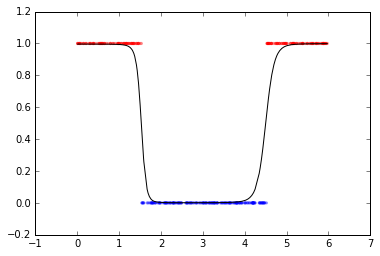

In [14]:
prob = tf.nn.sigmoid(y_lin).eval()
plt.scatter(x_train, y_train, s=5, alpha=0.3, color= color)
plt.plot(x_train, prob, c='k')

Below we visualize how the second layer uses the result from the first layer.

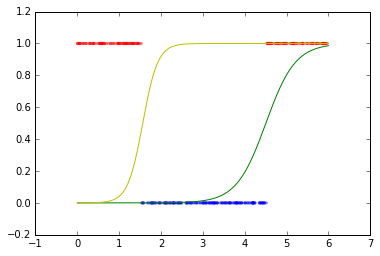

In [15]:
plt.scatter(x_train, y_train, s=5, alpha=0.3, color= color)
pts = np.linspace(0,6,800)
b = b_1.eval()
w = w_1.eval()

def sigmoid(x):
    x = tf.constant(x, dtype=tf.float32)
    result = tf.nn.sigmoid(x).eval()
    return result

curve1 = sigmoid(b[0,0] + w[0,0]*pts)
curve2 = sigmoid(b[0,1] + w[0,1]*pts)
plt.plot(pts, curve1,'g')
plt.plot(pts, curve2,'y')
sess.close()

It would be better to put everything together:

In [16]:
class One_layer_of_size_two(object):
    def __init__(self):
        self.__w1 = None
        self.__b1 = None
        self.__w2 = None
        self.__b1 = None
        
    def __initialize_model(self, x_train, y_train):
        x = tf.constant(x_train, dtype=tf.float32)
        y = tf.constant(y_train, dtype=tf.float32)
        w_1 = tf.Variable(tf.truncated_normal([1,2], stddev=0.1))
        b_1 = tf.Variable(tf.constant(0.1, shape=[1,2]))
        hidden = tf.nn.sigmoid(tf.add(tf.matmul(x, w_1), b_1))
        w_2 = tf.Variable(tf.truncated_normal([2,1], stddev=0.1))
        b_2 = tf.Variable(tf.constant(0.1, shape=[1,1]))
        y_lin = tf.add(tf.matmul(hidden, w_2), b_2)
        loss = -1*tf.reduce_mean(y_lin*y - tf.log(1+tf.exp(y_lin)), 0)
        tf.global_variables_initializer().run()
        train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
        return train_step, w_1, b_1, w_2, b_2
        
    def fit(self, x_train, y_train, steps=20000):
        train_step, w_1, b_1, w_2, b_2 = self.__initialize_model(x_train, y_train)
        tf.global_variables_initializer().run()
        for i in range(steps):
            train_step.run()
            
        self.__w1 = w_1.eval()
        self.__b1 = b_1.eval()
        self.__w2 = w_2.eval()
        self.__b2 = b_2.eval()
    
    def __sigmoid(self, x):
        x = tf.constant(x, dtype=tf.float32)
        result = tf.nn.sigmoid(x).eval()
        return result
        
    def predict_prob(self, x_train):
        w1 = self.__w1
        b1 = self.__b1
        w2 = self.__w2
        b2 = self.__b2
        y_lin = np.dot(self.__sigmoid(np.dot(x_train, w1)+b1), w2)+b2
        return self.__sigmoid(y_lin)
    
    @property
    def w1(self):
        return self.__w1
    
    @property
    def b1(self):
        return self.__b1
    
    @property
    def w2(self):
        return self.__w2
    
    @property
    def b2(self):
        return self.__b2

Our goal is to be able to work as in `sklearn`:

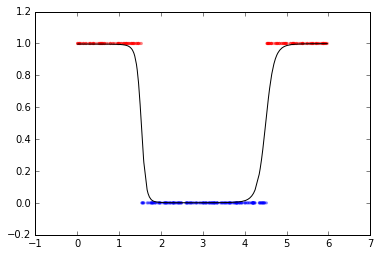

In [18]:
sess = tf.InteractiveSession()
nn = One_layer_of_size_two()
nn.fit(x_train, y_train)
prob = nn.predict_prob(x_train)
plt.scatter(x_train, y_train, s=5, alpha=0.3, color= color)
plt.plot(x_train, prob, c='k')

### Keep in mind that there is a session that we need to close
sess.close()

**Exercise**: Implement random initialization to the class.

---


### The MNIST dataset:

We need to make the code more general, so it's flexible with 
- amount of observations
- amount of features
- amount of labels

**Note:** Below we no longer implement `predict_prob`, instead we implement `predict`.

In [19]:
images = mnist.train.images
labels = mnist.train.labels

In [20]:
class One_layer(object):
    def __init__(self, size_hidden=2):
        self.__w1 = None
        self.__b1 = None
        self.__w2 = None
        self.__b1 = None
        self.__size_hidden = size_hidden
        
    def __initialize_model(self, x_train, y_train):
        num_observations= x_train.shape[0]
        num_features   = x_train.shape[1]
        num_labels     = y_train.shape[1]
        size_hidden    = self.__size_hidden
        
        x = tf.constant(x_train, dtype=tf.float32)
        y = tf.constant(y_train, dtype=tf.float32)
        w_1 = tf.Variable(tf.truncated_normal([num_features, size_hidden], stddev=0.1))
        b_1 = tf.Variable(tf.constant(0.1, shape=[1, size_hidden]))
        hidden = tf.nn.sigmoid(tf.add(tf.matmul(x, w_1), b_1))
        w_2 = tf.Variable(tf.truncated_normal([size_hidden, num_labels], stddev=0.1))
        b_2 = tf.Variable(tf.constant(0.1, shape=[1,num_labels]))
        y_lin = tf.add(tf.matmul(hidden, w_2), b_2)
        
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_lin, labels=y))
        
        #tf.global_variables_initializer().run()
        train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)
        return train_step, w_1, b_1, w_2, b_2
        
    def fit(self, x_train, y_train, steps=20000):
        train_step, w_1, b_1, w_2, b_2 = self.__initialize_model(x_train, y_train)
        tf.global_variables_initializer().run()
        for i in range(steps):
            train_step.run()
            
        self.__w1 = w_1.eval()
        self.__b1 = b_1.eval()
        self.__w2 = w_2.eval()
        self.__b2 = b_2.eval()
    
    def __sigmoid(self, x):
        x = tf.constant(x, dtype=tf.float32)
        result = tf.nn.sigmoid(x).eval()
        return result
        
    def predict(self, x_train):
        w1 = self.__w1
        b1 = self.__b1
        w2 = self.__w2
        b2 = self.__b2
        y_lin = np.dot(self.__sigmoid(np.dot(x_train, w1)+b1), w2)+b2
        return tf.argmax(y_lin, 1).eval()
        
    
    @property
    def w1(self):
        return self.__w1
    
    @property
    def b1(self):
        return self.__b1
    
    @property
    def w2(self):
        return self.__w2
    
    @property
    def b2(self):
        return self.__b2

In [21]:
start = time.time()
sess = tf.InteractiveSession()
nn = One_layer(size_hidden=10)
nn.fit(images, labels, steps=200)
predict = nn.predict(images)
print 'Accuracy: ', np.mean(predict == np.argmax(labels, 1))
print 'Time elapsed: ', time.time() - start
sess.close()

Accuracy:  0.445690909091
Time elapsed:  54.1670110226


We saw the accuracy is less than 60%. One thing we might want to do is to increase the steps, but it is likely to be very slow. Below we introduce the concept of batch, where we need another TensorFlow type: **`placeholder`**.

In [22]:
class One_layer_batch(object):
    def __init__(self, size_hidden=2):
        self.__w1 = None
        self.__b1 = None
        self.__w2 = None
        self.__b1 = None
        self.__size_hidden = size_hidden
        
    def __initialize_model(self, x_train, y_train):
        num_observations= x_train.shape[0]
        num_features   = x_train.shape[1]
        num_labels     = y_train.shape[1]
        size_hidden    = self.__size_hidden
        
        x = tf.placeholder(tf.float32, shape=[None, num_features])
        y = tf.placeholder(tf.float32, shape=[None, num_labels])
        w_1 = tf.Variable(tf.truncated_normal([num_features, size_hidden], stddev=0.1))
        b_1 = tf.Variable(tf.constant(0.1, shape=[1, size_hidden]))
        hidden = tf.nn.sigmoid(tf.add(tf.matmul(x, w_1), b_1))
        w_2 = tf.Variable(tf.truncated_normal([size_hidden, num_labels], stddev=0.1))
        b_2 = tf.Variable(tf.constant(0.1, shape=[1,num_labels]))
        y_lin = tf.add(tf.matmul(hidden, w_2), b_2)
        
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_lin, labels=y))
        train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)
        return train_step, x, y, w_1, b_1, w_2, b_2
        
    def fit(self, x_train, y_train, batch_size = 100,increment = 20, steps = 10000):
        train_step, x, y, w_1, b_1, w_2, b_2 = self.__initialize_model(x_train, y_train)
        
        num_observations = x_train.shape[0]
        tf.global_variables_initializer().run()
        for i in range(steps):
            start_ = (i*20) % num_observations
            end_   = min(num_observations, start_ + batch_size)
            x_batch = x_train[start_:end_,:]
            y_batch = y_train[start_:end_,:]
            train_step.run(feed_dict={x: x_batch, y: y_batch})

            
        self.__w1 = w_1.eval()
        self.__b1 = b_1.eval()
        self.__w2 = w_2.eval()
        self.__b2 = b_2.eval()
    
    def __sigmoid(self, x):
        x = tf.constant(x, dtype=tf.float32)
        result = tf.nn.sigmoid(x).eval()
        return result
        
    def predict(self, x_train):
        w1 = self.__w1
        b1 = self.__b1
        w2 = self.__w2
        b2 = self.__b2
        y_lin = np.dot(self.__sigmoid(np.dot(x_train, w1)+b1), w2)+b2
        return tf.argmax(y_lin, 1).eval()
        
    
    @property
    def w1(self):
        return self.__w1
    
    @property
    def b1(self):
        return self.__b1
    
    @property
    def w2(self):
        return self.__w2
    
    @property
    def b2(self):
        return self.__b2

In [23]:
start = time.time()
sess = tf.InteractiveSession()
nn = One_layer_batch(size_hidden=40)
nn.fit(images, labels, batch_size = 100, increment = 20, steps = 3000)
predict = nn.predict(images)
print 'Training Accuracy: ', np.mean(predict == np.argmax(labels, 1))
predict = nn.predict(mnist.validation.images)
print 'Validation Accuracy: ', np.mean(predict == np.argmax(mnist.validation.labels, 1))
predict = nn.predict(mnist.test.images)
print 'Test Accuracy: ', np.mean(predict == np.argmax(mnist.test.labels, 1))
print 'Time elapsed: ', time.time()-start
sess.close()

Training Accuracy:  0.909763636364
Validation Accuracy:  0.9178
Test Accuracy:  0.9157
Time elapsed:  9.95774412155


In [24]:
start = time.time()
sess = tf.InteractiveSession()
nn = One_layer_batch(size_hidden=100)
nn.fit(images, labels, batch_size = 100, increment = 20, steps = 30000)
predict = nn.predict(images)
print 'Training Accuracy: ', np.mean(predict == np.argmax(labels, 1))
predict = nn.predict(mnist.validation.images)
print 'Validation Accuracy: ', np.mean(predict == np.argmax(mnist.validation.labels, 1))
predict = nn.predict(mnist.test.images)
print 'Test Accuracy: ', np.mean(predict == np.argmax(mnist.test.labels, 1))
print 'Time elapsed: ', time.time()-start
sess.close()

Training Accuracy:  0.974745454545
Validation Accuracy:  0.9716
Test Accuracy:  0.9683
Time elapsed:  77.3404278755


In [34]:
start = time.time()
sess = tf.InteractiveSession()
nn = One_layer_batch(size_hidden=300)
nn.fit(images, labels, batch_size = 800, increment = 20, steps = 30000)
predict = nn.predict(images)
print 'Training Accuracy: ', np.mean(predict == np.argmax(labels, 1))
predict = nn.predict(mnist.validation.images)
print 'Validation Accuracy: ', np.mean(predict == np.argmax(mnist.validation.labels, 1))
predict = nn.predict(mnist.test.images)
print 'Test Accuracy: ', np.mean(predict == np.argmax(mnist.test.labels, 1))
print 'Time elapsed: ', time.time()-start
sess.close()

Training Accuracy:  0.976636363636
Validation Accuracy:  0.9704
Test Accuracy:  0.9686
Time elapsed:  975.451106071


**Exercise** How would you tune this model?

### Convolutional Neural Network



In [14]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], padding='SAME')
    

        
        
#### From here!!!
start = time.time()
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_train = tf.reshape(x, [-1,28,28,1])
h_conv1 = tf.nn.relu(conv2d(x_train, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2
        
        
sess = tf.InteractiveSession()       
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20001):
    batch = mnist.train.next_batch(50)
    if i%500 == 0:
        print "step %d, time elasped %.3f"% (i, time.time()-start)
    train_step.run(feed_dict={x: batch[0], y: batch[1]})

print("validation accuracy %g"%accuracy.eval(feed_dict={x: mnist.validation.images, y: mnist.validation.labels}))
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))

step 0, time elasped 0.623
step 100, time elasped 17.814
step 200, time elasped 35.362
step 300, time elasped 52.717
step 400, time elasped 70.022
step 500, time elasped 87.220
step 600, time elasped 104.404
step 700, time elasped 121.544
step 800, time elasped 138.675
step 900, time elasped 155.800
step 1000, time elasped 172.916
step 1100, time elasped 190.171
step 1200, time elasped 207.364
step 1300, time elasped 224.506
step 1400, time elasped 241.635
step 1500, time elasped 258.720
step 1600, time elasped 275.866
step 1700, time elasped 293.020
step 1800, time elasped 310.228
step 1900, time elasped 327.406
step 2000, time elasped 344.551
step 2100, time elasped 361.683
step 2200, time elasped 379.017
step 2300, time elasped 396.179
step 2400, time elasped 413.323
step 2500, time elasped 430.491
step 2600, time elasped 447.637
step 2700, time elasped 464.795
step 2800, time elasped 481.922
step 2900, time elasped 499.046
step 3000, time elasped 516.190
step 3100, time elasped 533

In [ ]:
sess.close()